# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

# Install the dependencies

In [1]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np
from n2gem.metrics import gem_build_coverage, gem_build_density
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from fastai.vision.all import *
from fastai.vision import *

In [3]:
import medmnist
from medmnist import INFO, Evaluator

In [4]:
from utils import *

Fix the seed generator

In [5]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(device); #print(torch.cuda.memory_allocated())
#torch.cuda.device_count()

In [7]:
import pymde

In [ ]:
#from skmultilearn.model_selection import iterative_train_test_split

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------

# Datasets

### MNIST dataset 

In [8]:
def load_mnist():
    """Function to load the mnist
        The following transform is aaplied: Normalize:(0.1307,)(0.3081,)
    
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081))
    ])
    train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
    test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)
    
    return train_set, test_set

train_set, test_set = load_mnist()

Concat dataset and make grid of images

In [9]:
dataset = torch.utils.data.ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)

In [ ]:
r= []
for i in range(10):
    r.append(np.where(np.array(Y)==i)[0][1])

In [ ]:
grid = torchvision.utils.make_grid(torch.from_numpy(np.array(X)[r]), 4, padding=1, pad_value=1)
grid.shape

In [ ]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(grid.permute(1,2,0))
#plt.savefig('organImagesPaper.png')

### MEDMNIST dataset 

In [ ]:
#from torch.utils.data import Dataset

data_transform = torchvision.transforms.Compose([
    #torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Normalize((0.6146,),(0.1537,)) # pathmnist grayscale-normalize values
    #torchvision.transforms.Normalize((0.74,0.53,0.71), (0.12,0.18,0.13)) # pathmnist RGB normalize values
    #torchvision.transforms.Normalize((0.5,0.5, 0.5), (0.5,0.5,0.5)) 
    #torchvision.transforms.Normalize((0.4938), (0.2381))  # chestmnist
    #torchvision.transforms.Normalize((0.4657), (0.2936))  # organmnist
    
])

class LoadMed(torch.utils.data.Dataset):
    """
    Class to load and form tensor datasets
    
    overload of the torch.utils.data.Dataset
    """
    
    def __init__(self, imgs, labels, transform):
        
        self.images = imgs
        self.labels = labels
        self.transform = transform
        
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        
        img, target = self.images[idx], self.labels[idx].astype(int)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        

        return img, target
        
        
        
#npz_file = np.load('/home/venkat31/.medmnist/pathmnist.npz')
npz_file = np.load('/home/venkat31/.medmnist/organamnist.npz')

train_imgs = npz_file['train_images']
test_imgs = npz_file['test_images']
val_imgs = npz_file['val_images']

train_labels = npz_file['train_labels']
test_labels = npz_file['test_labels']
val_labels = npz_file['val_labels']

In [ ]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
#download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
print(n_classes)

In [ ]:
arr_X_dataset = np.concatenate([train_imgs, test_imgs, val_imgs])
arr_Y_dataset = np.concatenate([train_labels, test_labels, val_labels])

In [ ]:
# plot the labels of the dataset
plt.hist(arr_Y_dataset.ravel(),  rwidth=0.96, bins=11)
plt.xticks(np.arange(0,11,1), np.arange(0,11,1))
plt.xlabel('Class')
plt.ylabel('frequency')
plt.title('Organ mnist dataset')
plt.savefig('Organmnist_lables_hist.png')

#### form the datset using the ```LoadMed```

In [ ]:
dataset = LoadMed(arr_X_dataset, arr_Y_dataset, data_transform)

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------

### Combine the datasets and stratify split 
- Combine train and test
- form the model_dataset[training+ test] and validation set
- obtain training & test set to train on the model from model_dataset

In [10]:
# mnist
X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(False, 0.03, 0.2, train_set=train_set, test_set=test_set)

# pathmnist
#X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(dataset, 0.05, 0.2)

# organmnist
#X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(dataset, 0.08, 0.2)

X_validation_set size:  (2100, 1, 28, 28)
Y_validation_set size:  2100
X_train_set size:  (54320, 1, 28, 28)
Y_train_set size:  54320
X_test_set size:  (13580, 1, 28, 28)
Y_test_set size:  13580


In [ ]:
plt.hist(model_set2, rwidth=0.96, bins=11, color='m')
plt.xticks(np.arange(0,11,1), np.arange(0,11,1))
plt.xlabel('Class')
plt.ylabel('frequency')
plt.title('Organ mnist vali dataset')
plt.savefig('Organmnist_valdatasetlables_hist.png')

### Convert the datasets to Torch.TensorDataset

In [11]:
train_set, test_set,  model_images, model_labels, validation_set = convert_tensor(X_trainset, X_testset, y_trainset, y_testset, X_validation,  y_validation)

torch.Size([54320, 1, 28, 28]) torch.Size([54320])


#### Save the model_dataset & validation_set images

In [ ]:
torch.save(model_images, 'organmnist_model_images.pt')
torch.save(model_labels, 'organmnist_model_labels.pt')

In [ ]:
torch.save(X_validation, 'organmnist_validation_images.pt')
torch.save(y_validation, 'organmnist_validation_labels.pt')

#### Dataloader for the CNN models

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)

-------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------

### Define the CNN model

In [ ]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=7)
        #self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*11*11, 128)
        #self.fc3 = nn.Linear(512, 32)
        self.fc4 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        #x = self.drop(self.conv2(x))
        #x = self.conv2(x)
        #x = F.relu(F.max_pool2d(x, 2))
        #print(x.shape)
        x = x.view(-1, 4*11*11)
        x = F.relu(self.fc1(x))
        #x = self.drop(x)
        #x = F.relu(self.fc3(x))
        #x = self.drop(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [78]:
# pathmnist 3C network
class PathNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 9))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
# for overfit model: dropout is removed and trained for 50 epochs
class OrgNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # organmnist
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128), # b4- conv5 output 64*4*4
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 11))
        # organmnist end
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        #x = self.conv6(x) # added extra for Grayscale pathmnist
        #x = self.conv7(x) # added extra for Grayscale pathmnist
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [67]:
# mnist
class MnNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        #return x

In [107]:
class FXMNIST(nn.Module):
    def __init__(self):
        super(FXMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [79]:
import torch.nn as nn
# for overfit model: dropout is removed and trained for 50 epochs
class FXMed(nn.Module):
    def __init__(self):
        super(FXMed, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # organmnist
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128), # b4- conv5 output 64*4*4
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 9))
        # organmnist end
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        #x = self.conv6(x) # added extra for Grayscale pathmnist
        #x = self.conv7(x) # added extra for Grayscale pathmnist
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# underfit model
class UFNet(nn.Module):
    def __init__(self):
        super(New, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(32*13*13, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 14)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        
        x = self.layer2(x)
        return x

Get the parameteres from the model

In [ ]:
model = NewNet()
#model = New()
#model = CNet()
param = [p for p in list(model.parameters()) if p.requires_grad]
uniq = {p.data_ptr(): p for p in list(model.parameters())}.values()
print(sum(p.numel() for p in uniq))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
#print(sum(p.numel() for p in model1.parameters() if p.requires_grad))

### Fastai classifier
- Fastai takes the available device by default

In [ ]:
data = DataLoaders(train_loader, test_loader)
f1score = F1Score(average='macro')
path_learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=[accuracy, f1score])
#learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#learn1 = Learner(data, CNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#chest_learn = Learner(data, NewNet(), loss_func=torch.nn.BCEWithLogitsLoss(), opt_func=Adam, metrics=accuracy_multi)
#chest_learn = Learner(data, NewNet(), loss_func=BCEWithLogitsLossFlat(), opt_func=Adam, metrics=[accuracy_multi])
#f1score = F1Score(average='macro')
#organ_learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=[accuracy, f1score])

In [ ]:
organ_learn.fit_one_cycle(2)

In [ ]:
organ_learn.unfreeze()
organ_learn.lr_find()

In [ ]:
organ_learn.fit_one_cycle(8, lr_max=1e-4)

In [ ]:
organ_learn.recorder.plot_loss()

In [ ]:
organ_learn.fine_tune(5)

## ResNet models 

In [ ]:
data = DataLoaders(train_loader, test_loader)
resmodel = models.resnet18(num_classes=14)
resmodel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7)
#model.fc = torch.nn.Linear(512, 10)
#print(model)

In [ ]:
print(sum(p.numel() for p in resmodel.parameters() if p.requires_grad))

In [ ]:
# resnet model for training 
learn = Learner(data, resmodel, loss_func=BCEWithLogitsLossFlat(), opt_func=Adam, metrics=accuracy_multi)

- Initial fit for the model

In [ ]:
learn.fit_one_cycle(3)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn1.fit_one_cycle(3, lr_max=1e-5)

In [ ]:
learn.fine_tune(5)

In [ ]:
#lss = learn.recorder.losses
#plt.plot(lss)
learn.recorder.plot_loss()
plt.savefig('resnet34_mnist.png')

In [ ]:
learn.save('./fastai_resnet34')
model_new = learn.load('fastai_resnet34')
torch.save(model_new.model.state_dict(), 'fastai_resnet34_weights.pt')

### - Save the fastai classifier
- By default it is saved in the /models folder with .pth extension

In [ ]:
learn.save('./fastai_resnet50_splitDataset')

In [ ]:
path_learn.save('./fastai_pathmnist_1C_89_NewNet')

In [ ]:
organ_learn.save('./fastai_organmnist_99_NewNet')

- Load the model(fastai) and save it as torch model for foolbox compatibility

In [ ]:
model_new = learn.load('fastai_cnn_NewNet_99_splitDataset')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_splitDataset_weights.pth')

In [ ]:
model_new1 = path_learn.load('fastai_pathmnist_1C_89_NewNet')
torch.save(model_new1.model.state_dict(), 'fastai_pathmnist_1C_89_NewNet_weights.pt')

In [ ]:
model_new1 = organ_learn.load('fastai_organmnist_99_NewNet')
torch.save(model_new1.model.state_dict(), 'fastai_organmnist_99_NewNet_weights.pt')

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

### Load model for the attack

In [80]:
# load the NewNet model
MyModel = NewNet() # MnNet, PathNet, OrgNet
#MyModel = FXMNIST()
FXMyModel = FXMed()

# --> for the attack change model to model.eval


# CNet
#MyModel = CNet()

# Resnet models
#MyModel = models.resnet50(num_classes=10)
#MyModel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7)

# mnist, pathmnist, organmnist
#MyModel.load_state_dict(torch.load('chkpt_files/fastai_organmnist_99_NewNet_weights.pt', map_location=device))
#MyModel.load_state_dict(torch.load('chkpt_files/fastai_cnn_NewNet_99_splitDataset_weights.pth', map_location=device))
#MyModel.load_state_dict(torch.load('./fastai_pathmnist_1C_89_NewNet_weights.pt', map_location=device))
MyModel.load_state_dict(torch.load('chkpt_files/fastai_pathmnist_96_NewNet_weights.pt', map_location=device))
FXMyModel.load_state_dict(torch.load('chkpt_files/fastai_pathmnist_96_NewNet_weights.pt', map_location=device))
MyModel.eval()
#print(torch.cuda.memory_allocated())
#print(MyModel)


# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

NewNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.

### Create a Pytorch model for foolbox attack

In [81]:
# mnist
#preprocess = dict(mean=0.1307, std=0.3081)

# pathmnist RGB normalize values
preprocess = dict(mean=[0.74,0.53,0.71], std=[0.12,0.18,0.13], axis=-3)

# pathmnist Grayscale normalize values
#preprocess = dict(mean=0.6146, std=0.1537)

# organmnist
#preprocess = dict(mean=0.4657, std=0.2936)

bound = (0, 1)
original_model = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

- Attack with 20 values of epsilons

In [82]:
attack2 = fb.attacks.FGSM()
epsilon = np.linspace(0.0, 1, num=20)

## Attack the model using 20 epsilon & ```FGSM attack```

- Attack the model using validation_dataset
- Stratify split model_set --> mnist, pathmnist

#### Load the the images

 mnist

In [12]:
md_images = torch.load('images/model_dataset_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/model_dataset_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/validation_labels.pt', map_location='cpu')

pathmnist RGB images

In [83]:
md_images = torch.load('images/pathmnist_model_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/pathmnist_model_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/pathmnist_validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/pathmnist_validation_labels.pt', map_location='cpu')

In [ ]:
print(np.unique(md_labels.cpu().numpy(), return_counts=True))
print(np.unique(np.array(vali_labels), return_counts=True))

organmnist

In [15]:
md_images = torch.load('images/organmnist_model_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/organmnist_model_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/organmnist_validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/organmnist_validation_labels.pt', map_location='cpu')

In [16]:
md_images.shape

torch.Size([54142, 1, 28, 28])

- stratify split the model_dataset 

In [84]:
# split the model_dataset to obtain 20000 images for the attack
#_, X_images, _, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.29455, random_state=42, stratify=md_labels.numpy())

# pathmnist
_, X_images,_, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.3, random_state=42, stratify=md_labels.numpy())

In [ ]:
plt.hist(np.array(vali_labels), rwidth=0.97, bins=11)
plt.ylabel('frequency')
plt.xlabel('class')
plt.title('Model_dataset_stratify(30000 images)')
#plt.savefig('pathmnist_vali_labels_hist.png')

Reshape and form the model_dataset tensors--> named as images

In [85]:
# mnist
#images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device))
#images.shape

# pathmnist
#images = ep.astensor(md_images.to(device))
images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device)) # 30000 model dataset images
#labels = ep.astensor(torch.from_numpy(np.array(y_labels)).to(device))


# organmnist
#images = ep.astensor(md_images.to(device))

images.shape

torch.Size([30547, 3, 28, 28])

### Compute Metrics- Density & Coverage

In [86]:
# resize the real images
real = images.raw.view(images.shape[0], -1)
real.shape, type(real)

(torch.Size([30547, 2352]), torch.Tensor)

#### --> model_dataset & validation set

In [87]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).to(device)
gen_labels = torch.from_numpy(np.array(vali_labels).reshape(-1)).to(device)
print(gen_validate.shape)


density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(f'density: {density_validate:.5f}, coverage: {coverage_validate:.5f}')

torch.Size([5359, 2352])
density: 0.83191, coverage: 0.49887


#### Attack the model using validation dataset

- convert the validation_images/labels into ep.tensor for foolbox attack compatibility

In [88]:
vali_imagesx = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_labelsx = ep.astensor(torch.from_numpy(np.array(vali_labels).reshape(-1)).to(device))
print(vali_imagesx.shape, vali_labelsx.shape)

torch.Size([5359, 3, 28, 28]) torch.Size([5359])


In [8]:
#fb.utils.accuracy(original_model, vali_imagesx, vali_labelsx)

### Perform the attack

In [90]:
#from utils import model_attack
adv_vali, adv_info_vali = model_attack(attack2, original_model, vali_imagesx, vali_labelsx, epsilon)

### Feature extraction

- extract the features from the input to softmax function
- follow this for model_dataset(real_FX) and validation_set(gen_validate)

In [97]:
vali_features = feature_extractor(vali_images, FXMyModel, 'images/before_softmax_acti/pathmnist/vali_images_FX_fc.txt')

In [24]:
md_images_FX = np.loadtxt('images/before_softmax_acti/orgmnist/vali_images_FX_fc.txt')
md_images_FX.shape

(4708, 11)

In [103]:
gen_validate = torch.from_numpy(np.loadtxt('images/before_softmax_acti/pathmnist/vali_images_FX_fc.txt'))
density_validate = gem_build_density(real_FX, real_FX.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real_FX, real_FX.shape[0], gen_validate, 'indexflatl2')
print(f'density: {density_validate:.5f}, coverage: {coverage_validate:.5f}')

density: 1.00649, coverage: 0.55924


#### Compute density & coverage between extracted features

- real_FX --> features extracted before softmax of the model_dataset(images)
- apply feature extraction to the generated adv. samples
- compute the metrics between these two feature tensors

In [98]:
# feature model dataset --> 20000 images(mnist), extract the features, save it as model_images_20000_FX
real_FX = torch.from_numpy(np.loadtxt('images/before_softmax_acti/pathmnist/model_images_FX_fc.txt'))

vali_den = []; vali_den1 = []; vali_cov = []; vali_cov1 = [];
for i in range(len(epsilon)):
    
    # single epsilon adv images
    adv_img = adv_vali[i].raw
    
    # get the feature vector from adv. samples
    gen = torch.from_numpy(feature_extractor(adv_img, FXMyModel, None))
   
    # density --> model_dataset & adv. feature vector
    #vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    # density --> feature model_dataset & adv. feature vector
    vali_den.append(gem_build_density(real_FX, real_FX.shape[0], gen, 'indexflatl2'))
    
    # coverage --> model_dataset & adv. feature vector
    #vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))
    # coverage --> feature model_dataset & adv. feature vector
    vali_cov.append(gem_build_coverage(real_FX, real_FX.shape[0], gen, 'indexflatl2'))
    
    if(i%3==0):print(i)
    

0
3
6
9
12
15
18


#### Compute Density & Coverage 

compute the metrics between the model_dataset and generated adv.samples(not the feature space)
- model_dataset and validation adversarial samples

In [21]:
vali_den = []
vali_cov = []

for i in range(len(epsilon)):

    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_vali[i].raw.view(adv_vali[i].shape[0], -1)

    # density
    vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))

    # coverage
    vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [99]:
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info_vali[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)

In [9]:
acc = 1-adv_info_vali.float32().mean(axis=-1)

In [100]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
density_data = []
for i in range(len(epsilon)):
    #print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_density: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_den[i]))
    density_data.append([epsilon[i], robust_accuracy[i], vali_den[i].cpu().numpy()])

density_data = np.array(density_data)

Density
Model_dataset & validation set: density: 0.83191


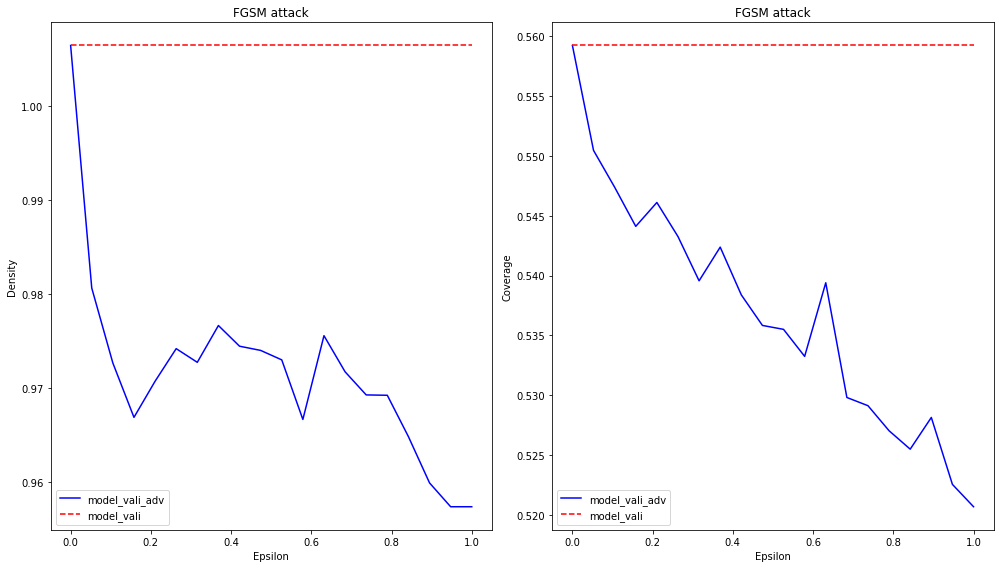

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
ax[0].plot(epsilon, vali_den, c='b', label='model_vali_adv')
ax[0].plot(epsilon, np.repeat(density_validate.cpu().numpy(), len(epsilon)), ls='--', c='r', label='model_vali')
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Density")
ax[0].set_title("FGSM attack")
ax[0].legend()
ax[1].plot(epsilon, vali_cov, c='b', label='model_vali_adv')
ax[1].plot(epsilon, np.repeat(coverage_validate.cpu().numpy(), len(epsilon)), ls='--', c='r', label='model_vali')
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Coverage")
ax[1].set_title("FGSM attack")
ax[1].legend()
fig.tight_layout()
plt.savefig("FGSM_attack_pathmnist_FX_model_vali_den_cov.png")

In [102]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_validate}")
print(f"Model_dataset & adversarial samples")
coverage_data = []
for i in range(len(epsilon)):
    #print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_coverage: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_cov[i]))
    coverage_data.append([epsilon[i], robust_accuracy[i], vali_cov[i].cpu().numpy()])

coverage_data = np.array(coverage_data)

Coverage
Model_dataset & validation set: coverage: 0.4988706111907959
Model_dataset & adversarial samples


### Save/write the density_data & coverage_data

- info. in each file: 
    - type of attack with model (FX- corresponds to feature extracted computation of metrics)
    - attack model with model_dataset -> model_dataset & adversarial samples
    - Column: Epsilon | Model_accuracy after attack | Metric between model_dataset & adv. samples 
    - Metric between model_dataset and validation_set

In [106]:
with open('FGSM_attack_pathmnist_FX_density.dat', 'w') as newfile:
    newfile.write("# FGSM attack NewNet model with FX model_dataset(30000 images)" + "\n" +
                 "# and validation_images(5329) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy FX_Vali_adv_density" + "\n" +
                 "# FX_Model_dataset & FX_validation set: " + str(density_validate.cpu().numpy()) + "\n" )

with open('FGSM_attack_pathmnist_FX_coverage.dat', 'w') as newfile:
    newfile.write("# FGSM attack NewNet model with FX model_dataset(30000 images)" + "\n" +
                 "# and validation_images(5329) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy  FX_Vali_adv_coverage" + "\n" +
                 "# FX_Model_dataset & FX_validation set: " + str(coverage_validate.cpu().numpy()) + "\n")
with open('FGSM_attack_pathmnist_FX_density.dat', 'a') as addfile:
    np.savetxt(addfile, density_data)
    
with open('FGSM_attack_pathmnist_FX_coverage.dat', 'a') as addfile:
    np.savetxt(addfile, coverage_data)

### Mixture of adv. samples

- random mixture of adv. samples into benign samples(validation_set) --> mixture dataset
- proportionate quantities: 25%, 50%, 75%
- compute metrics between the model_dataset and the created mixture dataset

In [ ]:
xx = np.random.choice(np.arange(5359), size=int(0.75*5359), replace=False)
#yy = np.random.choice(np.arange(4708), size=int(0.25*4708), replace=False)
mask = np.zeros(5359, dtype=np.bool)
mask[xx] = True

In [ ]:
zz = adv_vali[0][~mask]
zz.shape

In [ ]:
vali25_den=[]; vali25_cov=[]

for i in range(len(epsilon)):
    
    # for normal mixing
    #per_val = int(0.75*4708)
    #adv_vali25_imgs = adv_vali[i].raw[:per_val,...]
    #total_vali_set = torch.cat([vali_imagesx.raw[per_val:,...], adv_vali25_imgs])
    
    # for random mixing
    #xx_train,yy_train,xx_test, yy_test = train_test_split(vali_imagesx.raw, vali_labelsx.raw, train_size=0.5, random_state=42+(2*i), stratify=np.array(vali_labels))
    #xxa_train,yya_train,_,_ = train_test_split(adv_vali[i].raw, vali_labelsx.raw, train_size=0.5, random_state=42+i, stratify=np.array(vali_labels))
    
    
    #total_vali_set = torch.cat([xx_train, xxa_train])
    
    # for random mixing
    adv_vali25_imgs = adv_vali[i].raw[mask]
    total_vali_set = torch.cat([vali_imagesx.raw[~mask], adv_vali25_imgs])
    
    gen = total_vali_set.view(total_vali_set.shape[0], -1)
    
    # density
    vali25_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali25_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))
    
    if (i%5==0):print(i)

In [ ]:
metrics25 = []
for i in range(len(epsilon)):
    metrics25.append([epsilon[i], vali25_den[i].cpu().numpy(), vali25_cov[i].cpu().numpy()])
metrics25= np.array(metrics25)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(epsilon, metrics25[:,1], c='r', ls='--', label='25% mix')
plt.plot(epsilon, metrics50[:,1], c='b', ls='-.', label='50% mix')
plt.plot(epsilon, metrics75[:,1], c='g', ls=':',label='75% mix')
plt.plot(epsilon, vali_den, c='m', ls='-',label='full batch')
plt.plot(epsilon, np.repeat(density_validate.cpu().numpy(), len(epsilon)), c='k', label='model_vali')
plt.xlabel('epsilon')
plt.ylabel('density')
#plt.title('Density variation vs Adv samples')
plt.legend()
plt.savefig('FGSM_attack_pathmnist_3C_adv_randmix_den.png')

In [ ]:
metrics25 = []
for i in range(len(epsilon)):
    metrics25.append([epsilon[i], robust_accuracy[i], vali25_den[i].cpu().numpy(), vali25_cov[i].cpu().numpy()])
    
metrics25 = np.array(metrics25)

In [ ]:
with open('FGSM_attack_pathmnist_1C_NewNet_25randmix_valiadv.dat', 'w') as newfile:
    newfile.write("# FGSM attack NewNet model with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon" + "\n" +
                 "# 25% mix of adv vali samples random" + "\n" +
                 "# Epsilon Vali25_adv_den Vali25_adv_cov" + "\n" )
                 
with open('FGSM_attack_pathmnist_1C_NewNet_25randmix_valiadv.dat', 'a') as addfile:
    np.savetxt(addfile, metrics25)

### Metrics for FGSM Attack - stats

- for the computation of confidence bands
- ```Batch_modelvali_metrics``` - density & coverage between model_dataset& validation_dataset in batches of images
- ```Batch_modelvali_adv_metrics``` - attack the model in batches using validation_dataset. Computed density & coverage between model_dataset & validation_adv samples

In [ ]:
# mnist
#realx = torch.from_numpy(np.array(X_images)).view(len(X_images), -1).to(device)

# pathmnist
#realx = md_images.reshape(md_images.shape[0], -1).to(device)
vali_attk_images = torch.from_numpy(np.array(vali_images)).to(device)
vali_attk_labels = torch.from_numpy(np.array(vali_labels).reshape(-1)).to(device)
epsilon = np.linspace(0.0, 1, num=20)


In [ ]:
real.shape, vali_attk_images.shape, vali_attk_labels.shape

In [ ]:
Batch_modelvali_metrics = model_validation_metrics_batches(real, vali_attk_images, vali_attk_labels)

In [ ]:
with open('FGSM_attack_pathmnist_1C_100batch_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon in batches of 100 images" + "\n" +
                 "# metrics between model_dataset & validation dataset" + "\n" +
                 "# Model_vali_density Model_vali_coverage" + "\n" )
with open('FGSM_attack_pathmnist_1C_100batch_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_metrics))

In [ ]:
Batch_modelvali_adv_metrics = batch_validation_attack(real, vali_attk_images, vali_attk_labels, epsilon)

In [ ]:
with open('FGSM_attack_pathmnist_1C_100batch_adv_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(30547 images)" + "\n" +
                 "# and validation_images(5359) 20 epsilon in batches of 100 images" + "\n" +
                 "# metrics between model_dataset & adv validation dataset" + "\n" +
                 "# Model_vali_adv_density Model_vali_adv_coverage" + "\n" )
with open('FGSM_attack_pathmnist_1C_100batch_adv_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_adv_metrics))

### Pymde visualization

In [107]:
def dimPlot(images, labels, path):
    """
    Function to plot the images into 2D embedding using pymde
    
    Parameters
    -------------
    images: torch or numpy tensors, size: no_of_images x (flattened_dims_of_image)
    labels: torch or numpy array, corresponding labels for the images
    path: str, the file location to save plot in .png format
    
    Return
    ------------
    The 2 embedding of the images saved as .png image format
    """
    embdd = pymde.preserve_neighbors(images, embedding_dim=2, constraint=pymde.Standardized(), device=device).embed() #constraint=pymde.Standardized(),
    #embdd = pymde.preserve_distances(images, embedding_dim=2, constraint=pymde.Standardized()).embed() 
    pymde.plot(embdd, color_by=labels, marker_size=5, background_color='grey', figsize_inches=(7.0,7.0), savepath=path)
    

In [59]:
def freqPlot(true_label, predict_label, n_class, fname):
    """
    Function to visualize the predicted label vs true label for the model
    
    - to analyse the frequency of the classes after the attack
    
    Parameters
    -------------
    true_label: np.array or torch.Tensor, size:(no_of_examples), true label for the images
    predict_label: np.array or torch.Tensor, size:(no_of_examples), true label for the images
    n_class: int, the no. of classes in the dataset
    fname: str, the path to save the image
    
    Return
    -------------
    The histogram plot of predicted and actual labels saved in the given path
    """
    n1, bins1, _ = plt.hist(true_label, bins=np.arange(0,n_class+1,1), align='left', alpha=0.5, color='r', edgecolor='k', label='true')
    n2, bins2, _ = plt.hist(predict_label, bins=np.arange(0,n_class+1,1), align='left', alpha=0.3, color='b', label='adv')
    plt.xticks(np.arange(0,n_class,1))
    plt.legend()
    plt.savefig(fname)
    plt.show()

In [60]:
# validation_images
z = np.array(vali_images).reshape(len(vali_images), -1)
zl = np.array(vali_labels).reshape(-1)

# feature extracted validation images
#z = np.loadtxt('images/before_softmax_acti/pathmnist/vali_images_FX_fc.txt')
#zl = np.array(vali_labels).reshape(-1)

z.shape, zl.shape

((2100, 784), (2100,))

In [112]:
#md_images.shape, md_labels.shape
#real.shape, np.array(y_labels).shape
real_FX.shape, type(vali_labels)

(torch.Size([30547, 9]), list)

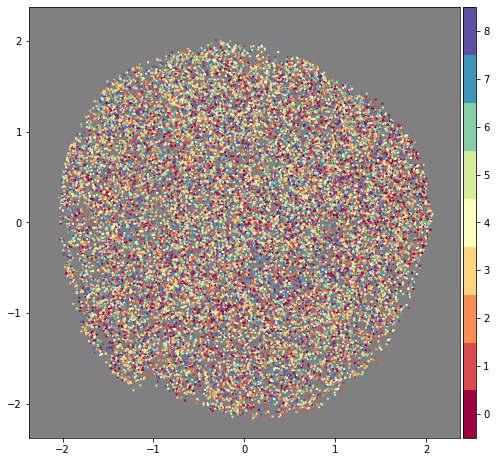

In [110]:
# pymde plot for model_dataset images( both model and FX_model)
dimPlot(real_FX, y_labels, None)
plt.tight_layout()
plt.savefig('pathmnist_pymde/FXmodel.png')

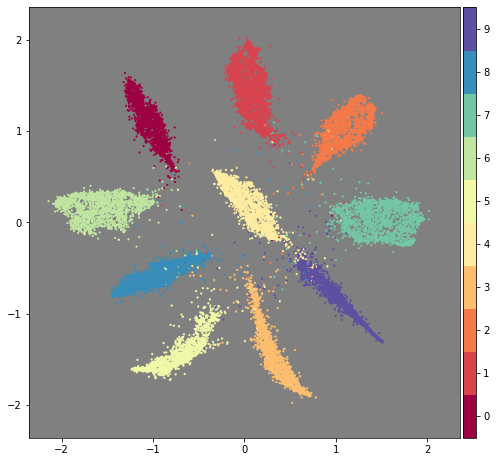

In [65]:
dimPlot(real_FX, np.array(y_labels),None)
plt.tight_layout()
plt.savefig('mnist_pymde/FXmodel_20000.png')

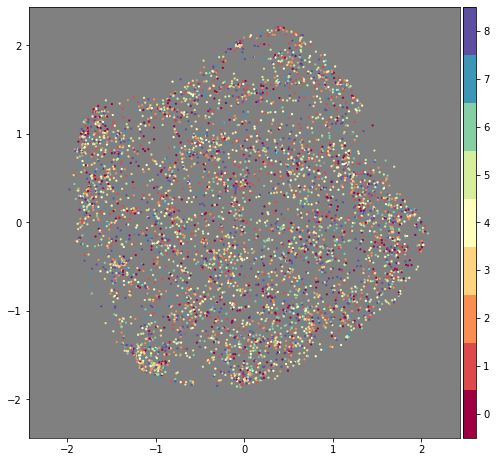

In [111]:
dimPlot(z, zl,None)
plt.tight_layout()
plt.savefig('pathmnist_pymde/FXvali.png')

#### Frequency plot

In [12]:
for i in range(len(epsilon)):
    with torch.no_grad():
        image = adv_vali[i].raw.cpu().to(device)
        predict = MyModel(image)
        predictions = np.argmax(predict.cpu().numpy(), axis=1)
    freqPlot(np.array(vali_labels).ravel(), predictions, 9, ('pathmnist_pymde/freq'+str(i)+'.png')) 

#### Plot pymde plot with the color label as predicted label

In [104]:
adv_predictions = []
for i in range(len(epsilon)):
    with torch.no_grad():
        image = adv_vali[i].raw.cpu()
        predict = MyModel(image)
        predictions = np.argmax(predict.cpu().numpy(), axis=1)
    #adv_predictions.append(predictions)
    dimPlot(adv_vali[i].raw.reshape(adv_vali[i].shape[0], -1), predictions,None)# ('orgmnist_adv_epi_'+str(i)+'.png'))
    plt.title(f'epi={(epsilon[i]):.3f}', loc='right')
    plt.tight_layout()
    plt.savefig('pathmnist_pymde/'+str(i)+'.png')

#### Pymde for adv. samples

- predict the labels for generated adv. samples
- extract features for each epsilon of adv. samples
- pymde plot the featured extracted adv. samples with predicted labels

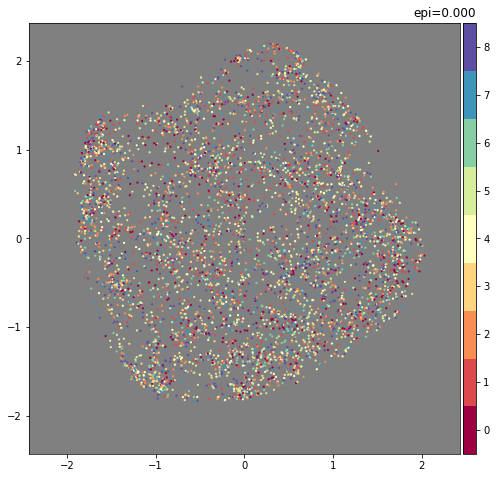

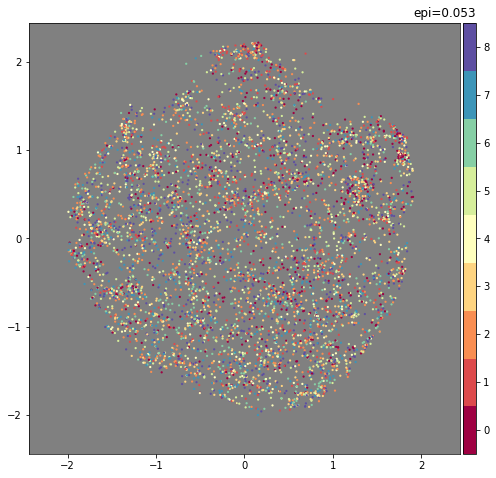

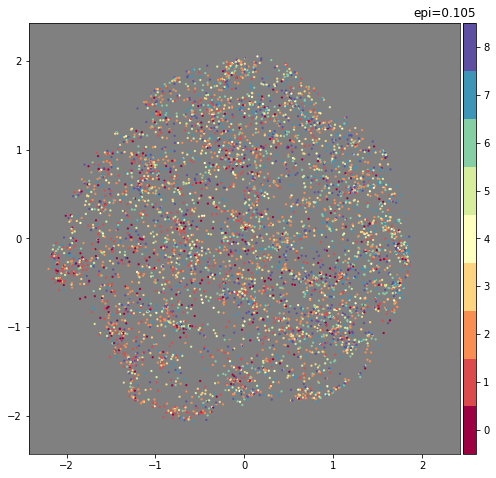

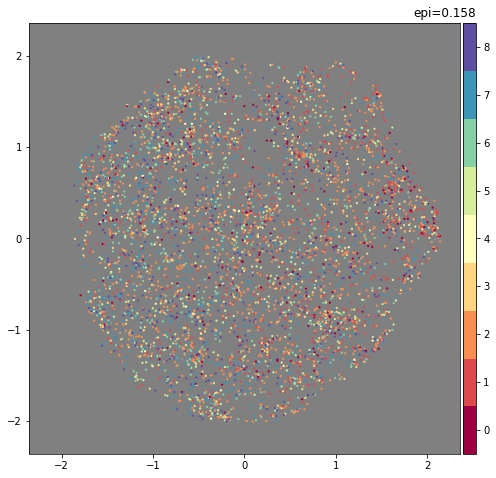

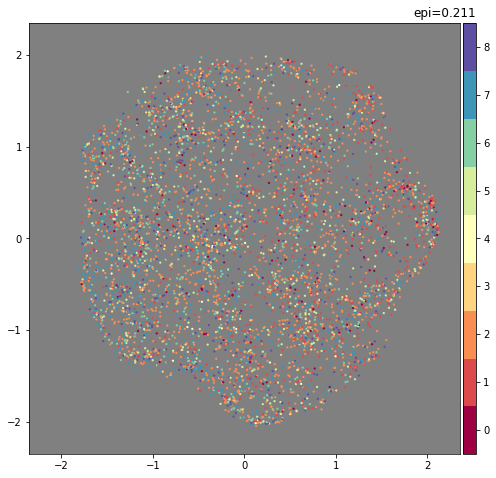

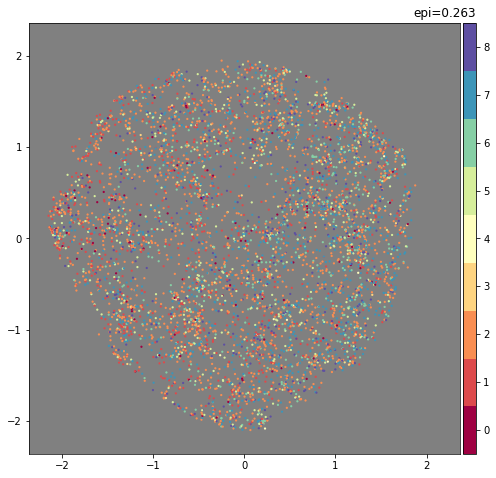

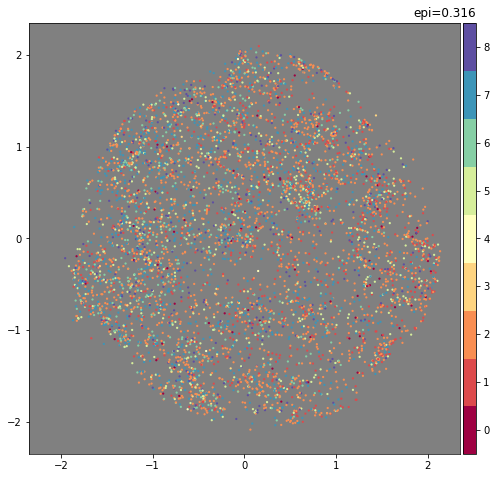

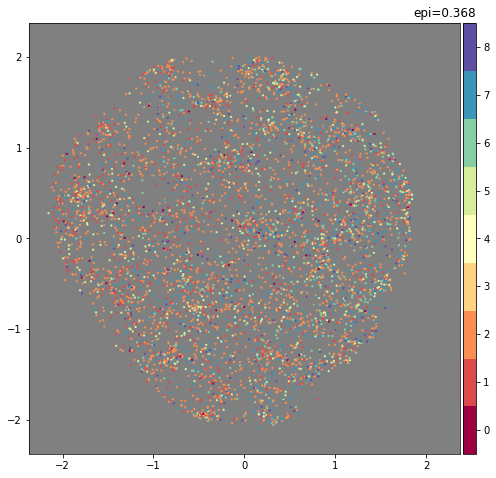

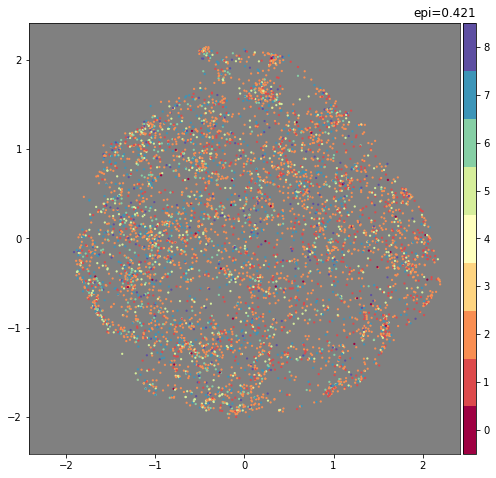

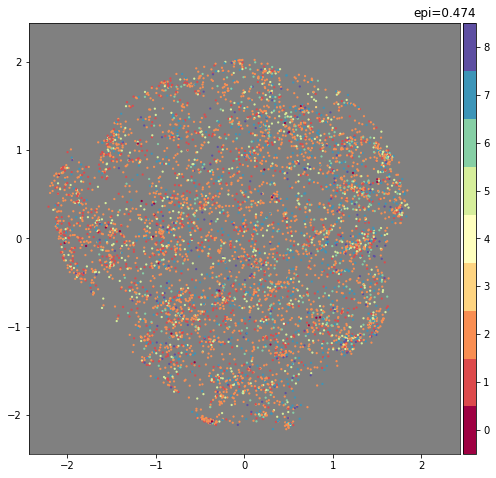

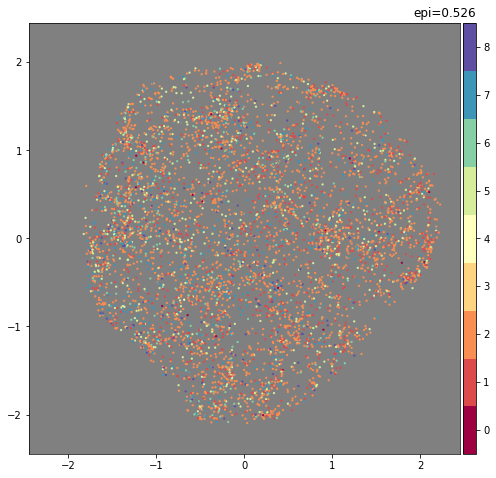

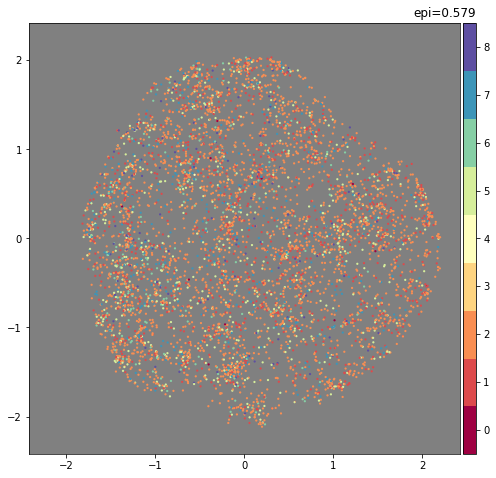

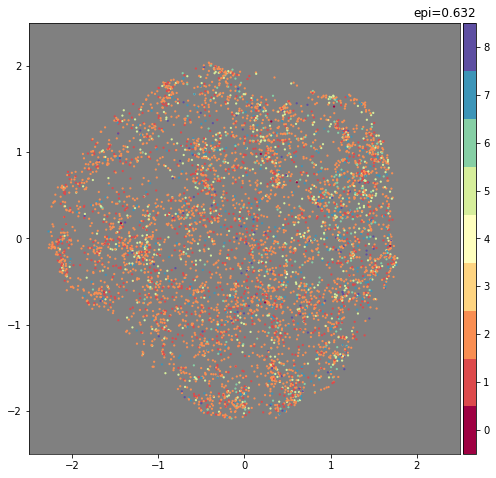

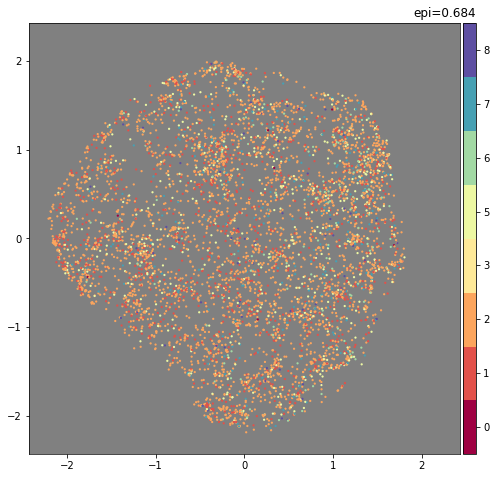

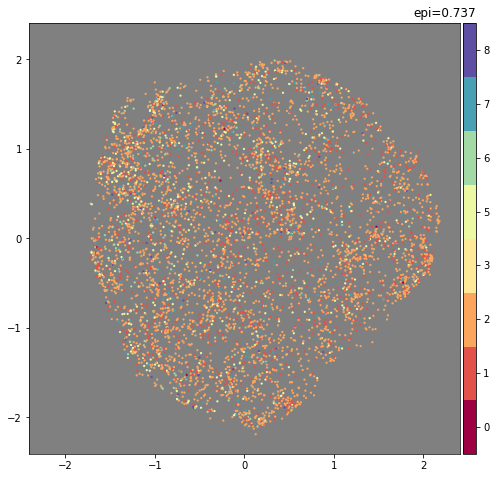

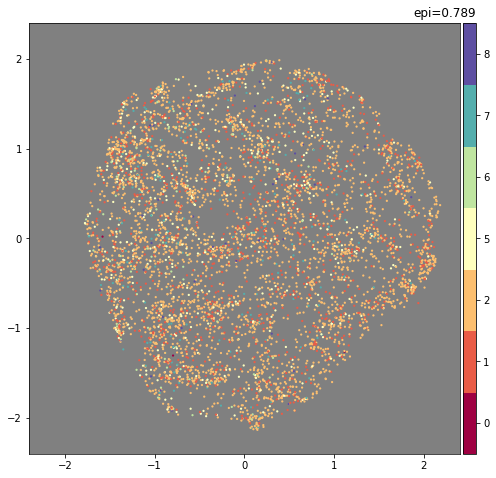

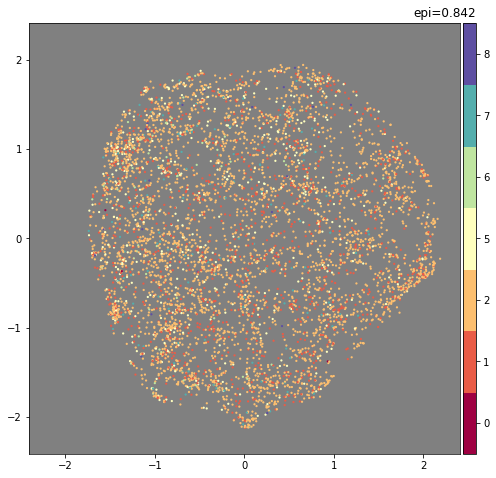

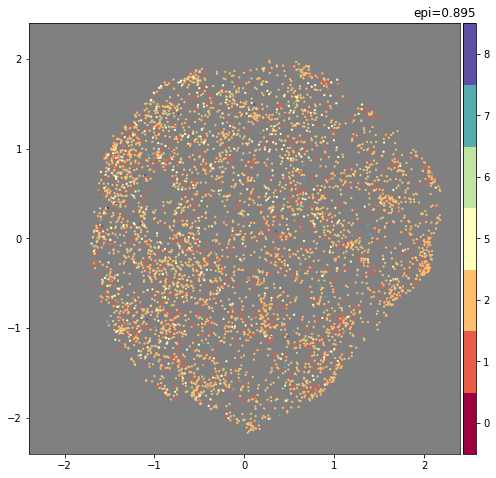

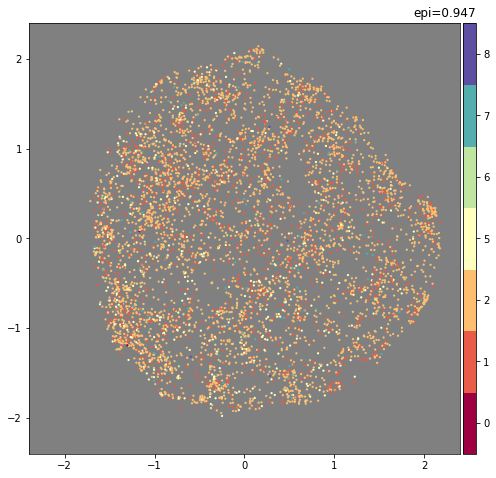

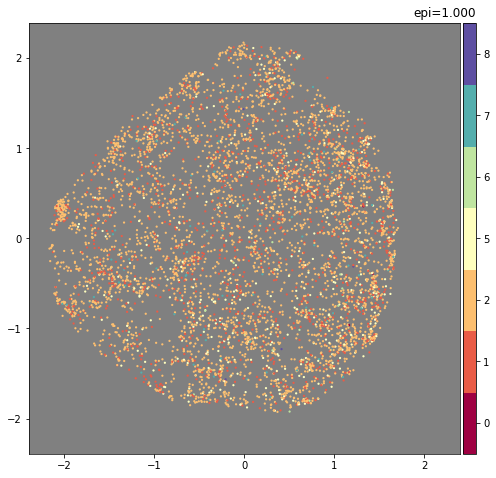

In [115]:
for i in range(len(epsilon)): 
    
    with torch.no_grad():
        image = adv_vali[i].raw.cpu().to(device)
        predict = MyModel(image)
        predictions = np.argmax(predict.cpu().numpy(), axis=1)
    
    # single epsilon adv images
    adv_img = adv_vali[i].raw
    
    # get the feature vector from adv. samples
    gen = torch.from_numpy(feature_extractor(adv_img, FXMyModel, None))
    
    dimPlot(gen, predictions, None)# ('orgmnist_adv_epi_'+str(i)+'.png'))
    plt.title(f'epi={(epsilon[i]):.3f}', loc='right')
    plt.tight_layout()
    plt.savefig('pathmnist_pymde/FXadv_pred'+str(i)+'.png')

## Attack the model using ```Boundary attack```

This attack works fine i.e, adversarial samples are created if epsilon is assigned as None

In [ ]:
# manage memory
#del md_images; del md_labels; del images; del labels
#torch.cuda.empty_cache()
#print(torch.cuda.memory_allocated())

In [ ]:
BdyAttack = fb.attacks.BoundaryAttack()

#### Test attack using images & labels from foolbox

This step is done to make sure adversarial samples are generated with the current version of foolbox

In [ ]:
test_imgs, test_labels = ep.astensors(*samples(original_model, dataset='mnist', batchsize=16))
raw_advs, clipped_advs, success = BdyAttack(original_model, test_imgs, test_labels, epsilons=None)

In [ ]:
robust_accuracy = 1 - success.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

#### Test attack using validation images

A subset of 10 images from the validation_set is used for the attack

In [ ]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))

In [ ]:
vali_attk_labels = vali_attk_labels.reshape(-1)

In [ ]:
vali_attk_labels.shape

In [ ]:
attak = fb.attacks.BoundaryAttack()
_, _, newsuccess = BdyAttack(original_model, vali_attk_images[:10,...], vali_attk_labels[:10], epsilons=None)

In [ ]:
robust_acc = 1 - newsuccess.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

### Attack the model using entire validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

In [ ]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))

In [ ]:
vali_attk_images.shape, type(vali_attk_labels)

### Perform init_attack

- attack using ```s_attack``` or ```n_attack``` with the validation_set 
- generate adv. samples --> ```adv_lsbu```

In [ ]:
s_attack = fb.attacks.SaltAndPepperNoiseAttack(steps=5000, across_channels=True)
n_attack = fb.attacks.LinearSearchBlendedUniformNoiseAttack(steps=2000, directions=5000)
#l_attack = fb.attacks.LinfDeepFoolAttack()
#lb_attack = fb.attacks.L0BrendelBethgeAttack()
#criterion = fb.criteria.Misclassification(vali_attk_labels)
_, adv_lsbu, adv_bdy_info = n_attack(original_model, vali_attk_images, vali_attk_labels.reshape(-1), epsilons=None)

In [ ]:
adv_bdy_info.float32()

In [ ]:
print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")

### Perform the Boundary attack

- use the generated adv. images as ```starting_pooint``` for the attack

In [ ]:
_, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images, vali_attk_labels, starting_points=adv_lsbu, epsilons=None) #starting_points=adv_lsbu,

### Compute Density & Coverage

Model_dataset and validation_Set

In [ ]:
vali_attk_images.shape, vali_attk_labels.shape, md_images.shape#, real.shape

In [ ]:
#real = md_images.view(md_images.shape[0], -1).to(device)
# images from the validation set
# for pathmnist 30000 model_dataset images are used 
gen_validate = vali_attk_images.raw.view(vali_attk_images.shape[0], -1)
gen_labels = vali_attk_labels
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

model_dataset & validation_dataset adversarials

In [ ]:
gen_adv_val = adv_bdy.raw.view(adv_bdy.shape[0], -1)
model_density_val = gem_build_density(real, real.shape[0], gen_adv_val, 'indexflatl2')
model_coverage_val = gem_build_coverage(real, real.shape[0], gen_adv_val, 'indexflatl2')
print(gen_adv_val.shape, real.shape)
print(model_density_val, model_coverage_val)

In [ ]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
print(f"Model_dataset & validation adv (2100): density: {model_density_val:.5f}")

### Mixture of adv. samples

- random mixture of adv. samples into validation_set
- compute metrics between mixture_set and model_dataset

In [ ]:
vali25_den=[]; vali25_cov=[]
xx = np.random.choice(np.arange(4708), size=int(0.25*4708), replace=False)
yy = np.random.choice(np.arange(4708), size=int(0.75*4708), replace=False)

    
# for normal mixing
#per_val = int(0.75*4708)
#adv_vali25_imgs = adv_bdy.raw[:per_val,...]
#total_vali_set = torch.cat([vali_attk_images.raw[per_val:,...], adv_vali25_imgs])

# for random mixing
adv_vali25_imgs = adv_bdy.raw[yy]
total_vali_set = torch.cat([vali_attk_images.raw[xx], adv_vali25_imgs])

gen = total_vali_set.view(total_vali_set.shape[0], -1)

# density
vali25_den = gem_build_density(real, real.shape[0], gen, 'indexflatl2')

# coverage
vali25_cov= gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
print(vali25_den, vali25_cov)

### Attack the model with validation_dataset in batches

- create the adversarial samples for each batch exclusively
- use these images as starting_points for boundary attack

#### Get the adversarial starting points for each Batch
- load the 100Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials( batch size of 100 images)
- load the 42Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials( batch size of 42 images)

In [ ]:
batches = np.arange(0, 4707, 100)
success = []
batch_adv_samples = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, batch_adv_lsbu, adv_bdy_info = n_attack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], epsilons=None)
    print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")
    success.append(adv_bdy_info); batch_adv_samples.append(batch_adv_lsbu.raw)

In [ ]:
batch_adv_lsbu_samples = torch.stack(batch_adv_samples)
torch.save(batch_adv_lsbu_samples, '140Batch_Vali_Adv_LSBU.pt')

In [ ]:
#batch_lsbu_adv = torch.load('100Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)
batch_lsbu_adv = torch.load('140Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)

### BoundaryAttack on the model using batches of validation_dataset

- form batches of valiodation_images
- perform attck using these images
- various batch_sizes:50, 100, 150, 200, 250, 300 (dependent on the dataset)

In [ ]:
# 53, 100, 150, 200, 250, 300 
batches = np.arange(0, 4707, 49)
batch_bdy_adv = []
batch_bdy_info = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], 
                                          epsilons=None) #starting_points=batch_lsbu_adv[i],
    batch_bdy_adv.append(adv_bdy); batch_bdy_info.append(adv_bdy_info)
    if(i%10==0):print(f"batch{i}")

### Metrics

- #### model_dataset & validation_dataset in batches
- #### model_deataset & validation adv in batches

In [ ]:
batch_density_validate = []
batch_coverage_validate = []
batch_model_density = []
batch_model_coverage = []
real = real.to(device)

for i in range(len(batches)-1):
    # model_dataset & validation_dataset in batches
    start = batches[i]; end= batches[i+1]
    bth_val_imgs = vali_attk_images[start:end,...]
    gen_validatex = bth_val_imgs.raw.view(bth_val_imgs.shape[0], -1)
    gen_labelsx = vali_attk_labels[start:end].raw
    density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
    coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
    
    # model_dataset & validation_dataset adversarials in batches
    gen_adv_valx = batch_bdy_adv[i].raw.view(batch_bdy_adv[i].shape[0], -1)
    model_density_valx = gem_build_density(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    model_coverage_valx = gem_build_coverage(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    
    batch_density_validate.append(density_validatex)
    batch_coverage_validate.append(coverage_validatex)
    batch_model_density.append(model_density_valx)
    batch_model_coverage.append(model_coverage_valx)


In [ ]:
real.shape, vali_attk_images.shape

### Save metrics to file

- info. in each file
    - attack name with dataset info.
    - density metric btw. model_dataset & validation_Set
    - density metric btw. model_dataset & adv. samples
    - coverage metric btw. model_dataset & validation_Set
    - coverage metric btw. model_dataset & adv. samples
    - Columns: Batch_number | model_validation_densiy | model_adv_density | model_validation_coverage
        model_adv_coverage

In [ ]:
with open('Boundary_attack_organmnist_100batch_metrics.dat', 'w') as newfile:
    newfile.write("# Boundary attack with validation_dataset(4708 images)" + "\n" +
                 "# and metrics using model_dataset(54142)" + "\n" +
                 "# Model_dataset & validation set: density: " + str(density_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (4708): density: " + str(model_density_val.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation set: coverage: " + str(coverage_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (4708): coverage: " + str(model_coverage_val.cpu().numpy()) + "\n" + 
                 "# batch_no model_val_density model_val_adv_density model_val_coverage model_val_adv_coverage" + "\n")
    
with open('Boundary_attack_organmnist_100batch_metrics.dat', 'a') as nefile:
    for i in range (len(batch_density_validate)):
        nefile.write(str(i)+ " " + str(batch_density_validate[i].cpu().numpy())+ " " + str(batch_model_density[i].cpu().numpy())+ " " +
                    str(batch_coverage_validate[i].cpu().numpy()) + " " + str(batch_model_coverage[i].cpu().numpy()) + "\n")

In [ ]:
with open('Boundary_attack_organmnist_49batch_metrics.dat', 'w') as newfile:
    newfile.write("# Boundary attack with validation_dataset(4708 images)" + "\n" +
                 "# and metrics using model_dataset(54142)" + "\n" +
                 "# Model_dataset & validation set: density: " + str(1.0169499) + "\n" +
                 "# Model_dataset & validation adv (4708): density: " + str(2.7256584) + "\n" +
                 "# Model_dataset & validation set: coverage: " + str(0.34394738) + "\n" +
                 "# Model_dataset & validation adv (4708): coverage: " + str(0.2428983) + "\n" + 
                 "# batch_no model_val_density model_val_adv_density model_val_coverage model_val_adv_coverage" + "\n")
    
with open('Boundary_attack_organmnist_49batch_metrics.dat', 'a') as nefile:
    for i in range (len(batch_density_validate)):
        nefile.write(str(i)+ " " + str(batch_density_validate[i].cpu().numpy())+ " " + str(batch_model_density[i].cpu().numpy())+ " " +
                    str(batch_coverage_validate[i].cpu().numpy()) + " " + str(batch_model_coverage[i].cpu().numpy()) + "\n")

## The End